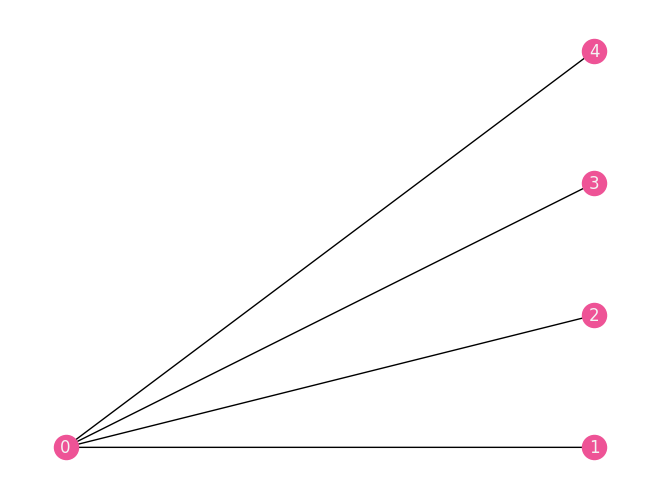

In [104]:
# 用于将 rustworkx 模块中的图形数据绘制成 Matplotlib 图形
import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

# 创建了一个空的 PyGraph 对象，它代表了一个图
G = rx.PyGraph()

# 向图中添加了 num_nodes 个节点和定义的边。
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

# 使用 mpl_draw 函数绘制了图。mpl_draw 函数需要传入图对象 G，以及一些绘制参数。
# pos=rx.bipartite_layout(G, {0}) 来指定节点的布局方式
# with_labels=True 表示在节点上显示标签
# node_color="#EE5396" 设置了节点的颜色
# font_color="#F4F4F4" 设置了节点标签的颜色。
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

In [105]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])

In [106]:
from qiskit.opflow import PauliSumOp


# 定义混合哈密顿量 H_M
def get_mixer_hamiltonian(num_qubits):
    pauli_list = []
    coeffs = []
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'
        pauli_str = ''.join(x_term)
        pauli_list.append((pauli_str, 1.0))
    mixer_hamiltonian = PauliSumOp.from_list(pauli_list)
    #
    # for i in range(num_qubits-1):
    #     for j in range(i + 1, num_qubits):
    #         # X_i X_j term
    #         x_term = ['I'] * num_qubits
    #         x_term[i] = 'X'
    #         x_term[j] = 'X'
    #         pauli_list.append(''.join(x_term))
    #         coeffs.append(np.pi/4)
    #
    #         # Y_i Y_j term
    #         y_term = ['I'] * num_qubits
    #         y_term[i] = 'Y'
    #         y_term[j] = 'Y'
    #         pauli_list.append(''.join(y_term))
    #         coeffs.append(np.pi/4)
    return mixer_hamiltonian

mixer_hamiltonian = get_mixer_hamiltonian(5)

In [107]:
from qiskit import QuantumCircuit
from matplotlib import pyplot as plt
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate

# 创建 QAOA 变分形式（ansatz）
p1 = 2  # QAOA 层数

params = ParameterVector('theta', 2 * p1)
ansatz = QuantumCircuit(5)

for layer in range(p1):
    # 应用问题哈密顿量
    ansatz.append(PauliEvolutionGate(hamiltonian, params[2 * layer]), list(range(5)))
    # 应用混合哈密顿量
    ansatz.append(PauliEvolutionGate(mixer_hamiltonian, params[2 * layer + 1]), list(range(5)))

In [108]:
from qiskit import transpile, Aer
from qiskit.primitives import Estimator
estimator = Estimator()
def objective_function(params):
    bound_circuit = ansatz.bind_parameters(params)
    bound_circuit = transpile(bound_circuit, Aer.get_backend('aer_simulator'))
    result = estimator.run([bound_circuit], [hamiltonian]).result()
    expectation_value = result.values[0]
    return expectation_value

In [109]:
import numpy as np
from qiskit_algorithms.optimizers import COBYLA

# 使用经典优化器最小化目标函数
initial_point = np.random.rand(2 * p1)

optimizer = COBYLA(maxiter=10000, tol=0.00001,disp=True)
result = optimizer.minimize(fun=objective_function, x0=initial_point)

# 计算最终的能量
final_energy = objective_function(result.x)
print("Final Energy:", final_energy)
print("Optimal Parameters:", result.x)

C:\Users\18330\AppData\Local\Temp\ipykernel_3432\700626292.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_circuit = ansatz.bind_parameters(params)


Final Energy: -3.9999999992258104
Optimal Parameters: [0.48908341 2.35619598 1.57080063 0.78540245]


In [110]:
from qiskit import execute, Aer
# 量子电路测量
bound_circuit = ansatz.bind_parameters(result.x)
bound_circuit.measure_all()

# 运行电路并获取测量结果
simulator = Aer.get_backend('qasm_simulator')
tqc = transpile(bound_circuit, simulator)
result = execute(tqc, backend=simulator, shots=10000).result()
counts = result.get_counts()

sorted_dict = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)

{'11110': 10000}


C:\Users\18330\AppData\Local\Temp\ipykernel_3432\3335126737.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_circuit = ansatz.bind_parameters(result.x)
